In [44]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection  import learning_curve
from sklearn.model_selection  import KFold

%matplotlib inline
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 100

In [4]:
curr_dir = os.getcwd()
data_path = os.path.join(curr_dir, "datasets", "listings_engineered.csv")
df = pd.read_csv(data_path)

### Separate one hot encoded features from standardized features as we will implement different transformations later

In [6]:
ohe = df[['price', 'no pets', 'no friends',
       'no parties', 'no smoking', 'room_type_Private room',
       'room_type_Shared room', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Bus', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Campsite',
       'property_type_Casa particular (Cuba)', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Cottage',
       'property_type_Dome house', 'property_type_Earth house',
       'property_type_Farm stay', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Nature lodge',
       'property_type_Other', 'property_type_Parking Space',
       'property_type_Plane', 'property_type_Ryokan (Japan)',
       'property_type_Serviced apartment', 'property_type_Tent',
       'property_type_Tiny house', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Villa', 'property_type_Yurt',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'neighbourhood_cleansed_Barnet',
       'neighbourhood_cleansed_Bexley', 'neighbourhood_cleansed_Brent',
       'neighbourhood_cleansed_Bromley', 'neighbourhood_cleansed_Camden',
       'neighbourhood_cleansed_City of London',
       'neighbourhood_cleansed_Croydon', 'neighbourhood_cleansed_Ealing',
       'neighbourhood_cleansed_Enfield', 'neighbourhood_cleansed_Greenwich',
       'neighbourhood_cleansed_Hackney',
       'neighbourhood_cleansed_Hammersmith and Fulham',
       'neighbourhood_cleansed_Haringey', 'neighbourhood_cleansed_Harrow',
       'neighbourhood_cleansed_Havering', 'neighbourhood_cleansed_Hillingdon',
       'neighbourhood_cleansed_Hounslow', 'neighbourhood_cleansed_Islington',
       'neighbourhood_cleansed_Kensington and Chelsea',
       'neighbourhood_cleansed_Kingston upon Thames',
       'neighbourhood_cleansed_Lambeth', 'neighbourhood_cleansed_Lewisham',
       'neighbourhood_cleansed_Merton', 'neighbourhood_cleansed_Newham',
       'neighbourhood_cleansed_Redbridge',
       'neighbourhood_cleansed_Richmond upon Thames',
       'neighbourhood_cleansed_Southwark', 'neighbourhood_cleansed_Sutton',
       'neighbourhood_cleansed_Tower Hamlets',
       'neighbourhood_cleansed_Waltham Forest',
       'neighbourhood_cleansed_Wandsworth',
       'neighbourhood_cleansed_Westminster']]

scaled = df[['accommodates', 'bathrooms', 'bedrooms', 'beds','number_of_reviews',
       'security_deposit', 'cleaning_fee', 'dist_to_bigben', 'dist_to_bigben_transformed',
       'minimum_nights', 'maximum_nights']]

### Standardise the data to have mean = 0 and standard deviation of 1

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(scaled)
standardized_features_df = pd.DataFrame(scaler.transform(scaled), columns=scaled.columns)

In [8]:
X = pd.concat([ohe, standardized_features_df], axis=1)
y = df["price"]

In [161]:
from sklearn.linear_model import SGDRegressor


def SGDR_model():
    """
    Stochastic Gradient Descent Regression Model which generally is
    supposed to be faster on larger datasets >10^5. Our dataset size
    is close to 10^5.
    
    Returns model object with initial hyperparameters.
    """
    print("SGD Regression")
    lr = SGDRegressor(alpha=0.8, 
                      penalty="l1",
                      max_iter=10000,
                      random_state=42)    
    return lr

def build_and_train_model(X, y, func):
    """
    Generalised model builder and trainer which outputs
    various parameters related to model parameters, 
    accuracy and errors metrics.
    """
    fn = func()
    X_train, X_test, y_train, y_test = \
        train_test_split(X.drop("price", axis=1), y, test_size=0.2, random_state=42)    
    model = fn.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    print("Training Score:", score)
    y_pred = model.predict(X_test)
    r_score = r2_score(y_test, y_pred)
    print("Testing Score:", r_score)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE:", rmse)
    return {"model" : model,
            "params" : model.get_params(),
            "y_pred" : y_pred,
            "train_score" : score,
            "test_score" : r2_score,
            "rmse" : rmse}   

In [13]:
%%time
lr = build_and_train_model(X, y, SGDR_model)

SGD Regression
Training Score: 0.4384946457731433
Testing Score: 0.41821772630583065
RMSE: 79.06633715327847
Wall time: 762 ms


Immediately we can see that this engineered model outperforms the baseline model implemented in the FeatureEngineering notebook (RMSE: 87.87).

In [159]:
def ols_stats_models(X, y):
    """
    Fit train and test data using OLS model from
    stats models package.
    """
    X_train, X_test, y_train, y_test = \
        train_test_split(X.drop("price", axis=1), y, test_size=0.2, random_state=42)  
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)
    return {"summary" : model.summary(),
            "y_test" : y_test,
            "y_pred" : y_pred}

In [15]:
%%time
ols = ols_stats_models(X, y)

Wall time: 834 ms


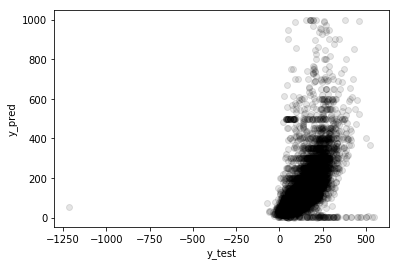

In [16]:
plt.scatter(ols["y_pred"], ols["y_test"], color="k", alpha=0.1)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

It is interesting to note that y_pred has a very large negative outlier, skewing the results, otherwise there does seem to be a decent positive correlation between y_pred and y_test examining by eye.

**Results of OLS regression using stats models. Features with P values <= 0.05 are significant.**

However note that that the OLS using stats models does not implement regularization hence R^2
will be different to the implementation with scikit-learn.

In [17]:
ols["summary"]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     624.9
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:02:55   Log-Likelihood:            -3.8654e+05
No. Observations:               67080   AIC:                         7.733e+05
Df Residuals:                   66987   BIC:                         7.741e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            94.6751     18.138      5.220      0.000      59.125     130.226
no pets                                           8.5978      1.458      5.899      0.000       5.741      11.455
no friends                                        4.7029     10.050      0.468      0.640     -14.996      24.402
no parties                                        3.1572      1.059      2.980      0.003       1.081       5.234
no smoking                                       -9.8946      0.992     -9.973      0.000     -11.839      -7.950
room_type_Private room                          -36.2838      0.823    -44.094      0.000     -37.897     -34.671
room_type_Shared room                           -57.6592      3.533    -16.319      0.000     -64.585     -50.734
property_type_Apartment                         -28.7207     11.632     -2.469      0.014     -51.519      -5.922
property_type_Barn                               20.3607     27.009      0.754      0.451     -32.577      73.298
property_type_Bed and breakfast                  -6.0356     11.990     -0.503      0.615     -29.536      17.465
property_type_Boat                              -18.6665     16.447     -1.135      0.256     -50.903      13.570
property_type_Boutique hotel                     50.1496     12.953      3.872      0.000      24.762      75.537
property_type_Bungalow                          -16.5887     14.003     -1.185      0.236     -44.035      10.858
property_type_Bus                               -75.0168     55.742     -1.346      0.178    -184.270      34.237
property_type_Cabin                             -22.3256     22.508     -0.992      0.321     -66.442      21.790
property_type_Camper/RV                         -16.3048     25.987     -0.627      0.530     -67.240      34.630
property_type_Campsite                          -66.5451     55.708     -1.195      0.232    -175.732      42.642
property_type_Casa particular (Cuba)            -19.4865     22.505     -0.866      0.387     -63.597      24.623
property_type_Chalet                            -22.1154     25.995     -0.851      0.395     -73.066      28.835
property_type_Condominium                       -22.7113     11.911     -1.907      0.057     -46.056       0.634
property_type_Cottage                           -24.9930     15.151     -1.650      0.099     -54.688       4.702
property_type_Dome house                        -64.2474     46.008     -1.396      0.163    -154.423      25.928
property_type_Earth house                       -33.3238     28.207     -1.181      0.237     -88.610      21.963
property_type_Farm stay                         -12.0278     45.991     -0.262      0.794    -102.171      78.115
prope

In [154]:
def plot_learning_curves(X, y, model, name):
    """
    Compares the training and validation scores of an estimator
    model for varying training sample size. It gives insight into the 
    estimator's variance and bias error, and whether increasing
    training size is beneficial or not.
    """
    
    X = X.drop("price", axis=1)
    cv = KFold(5, shuffle=True)
    model.fit(X, y)
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, 
                                                            y, 
                                                            n_jobs=-1, 
                                                            cv=cv, 
                                                            train_sizes=[0.1, 0.2, 0.4, 0.8], 
                                                            verbose=0)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 7))
    plt.title(name)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-0.1, 1.1)
    plt.legend(loc="best")
    plt.show()

No handles with labels found to put in legend.


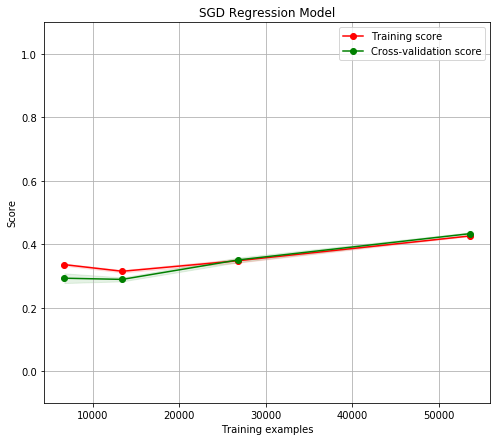

Wall time: 4.15 s


In [28]:
%%time
sgdr = SGDRegressor(alpha=0.8, 
                    penalty="l1",
                    max_iter=1000,
                    random_state=42)

plot_learning_curves(X, y, sgdr, 
                     "SGD Regression Model")

This simple SGD Regression model outperforms the baseline with low variance and bias with increasing training sample size.

## Calculating VIF score for multicollinearity detection

Variance inflation factor measures how much the variance of an estimated regression coefficient increases if features are correlated. Generally, if VIF > 5-10 = high multicollinearity.

In [30]:
%%time
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

Wall time: 2min 9s


In [153]:
feature_cols = vif[vif["VIF Factor"] < 10.0]["features"].values
vif.round(2).sort_values("VIF Factor").head(10)

,features,VIF Factor
92,maximum_nights,1.00
2,no friends,1.00
37,property_type_Plane,1.01
32,property_type_Lighthouse,1.01
31,property_type_Island,1.01
38,property_type_Ryokan (Japan),1.01
91,minimum_nights,1.01
36,property_type_Parking Space,1.01
40,property_type_Tent,1.02
43,property_type_Treehouse,1.02


In [36]:
X_vif_adj = X[feature_cols]

In [38]:
%%time
lr = build_and_train_model(X_vif_adj, y, SGDR_model)

SGD Regression
Training Score: 0.39763906118348175
Testing Score: 0.3767215226680942
RMSE: 81.83751676657187
Wall time: 625 ms


In [39]:
Q1 = X_vif_adj.quantile(0.25)
Q3 = X_vif_adj.quantile(0.75)
IQR = Q3 - Q1
outliers_removed = X_vif_adj[~((X_vif_adj < (Q1 - 1.5 * IQR))\
                           |(X_vif_adj > (Q3 + 1.5 * IQR))).any(axis=1)]

In [41]:
%%time
lr = build_and_train_model(outliers_removed, outliers_removed["price"], SGDR_model)

SGD Regression
Training Score: 0.49403862009992316
Testing Score: 0.4860543659812506
RMSE: 36.875325301775845
Wall time: 245 ms


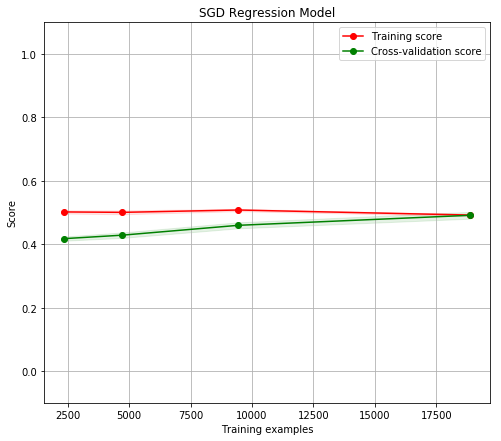

Wall time: 2.82 s


In [42]:
%%time
plot_learning_curves(outliers_removed, 
                     outliers_removed["price"],
                     sgdr, 
                     "SGD Regression Model")

Removing outliers, certainly seems to increase the R^2 score and reduces the RMSE considerably.There also seems to be an increase in variance as the gap between training and validation scores has increased slightly at low training size. The training score decreases with increasing training size around 10000 samples indicating large train sizes are not beneficial.

### Transformations of non-normal data

Shapiro-Wilk test: Checks if a random sample comes from a normal distribution

In [149]:
from sklearn.preprocessing import QuantileTransformer

def check_normality(series):
    """
    Uses the Shapiro-Wilk test to check if a random sample
    is normal (the null hypothesis) at the 95% confidence
    level. If the p-value is < 0.05, reject H0 and assume
    the distribution is non-normal.

    """
    np.random.seed(1)
    sample_size = 1000
    series = np.random.choice(series, sample_size)
    return stats.shapiro(series)[1]
    
scaled.agg(check_normality).sort_values(ascending=False)

dist_to_bigben                5.101615e-08
dist_to_bigben_transformed    5.024754e-22
accommodates                  6.921308e-31
bedrooms                      1.369261e-36
beds                          3.383509e-38
cleaning_fee                  9.193465e-39
security_deposit              2.622096e-39
bathrooms                     3.812933e-42
number_of_reviews             9.809089e-45
maximum_nights                0.000000e+00
minimum_nights                0.000000e+00
dtype: float64

Near zero p-values indicates most of the scaled features are non-normal. In order to transform to a normal distribution, we will use the Yeo-johnson transformation as it supports both positive and negative data (as opposed to the Box-cox transformation)

In [46]:
power_transformer = PowerTransformer(method="yeo-johnson")
scaled_transformed = power_transformer.fit(scaled).transform(scaled)
scaled_transformed_df = pd.DataFrame(scaled_transformed, columns=scaled.columns)

In [47]:
scaled_transformed_df.agg(check_normality).sort_values(ascending=False)

dist_to_bigben                4.169357e-06
dist_to_bigben_transformed    3.358915e-14
number_of_reviews             1.834858e-22
accommodates                  2.879717e-24
minimum_nights                5.582785e-27
cleaning_fee                  5.416386e-27
beds                          7.824247e-33
bedrooms                      1.962552e-34
maximum_nights                3.355761e-38
security_deposit              7.821992e-40
bathrooms                     2.385290e-41
dtype: float64

In [50]:
# Pairplot takes too long to load
# sns.pairplot(scaled_transformed_df)
# plt.show()

In [48]:
quantile_transformer = QuantileTransformer(output_distribution="normal")
scaled_quant = quantile_transformer.fit_transform(scaled)
scaled_quant_df = pd.DataFrame(scaled_quant, columns=scaled.columns)

In [51]:
scaled_quant_df.agg(check_normality).sort_values(ascending=False)

dist_to_bigben_transformed    9.705297e-01
dist_to_bigben                6.160737e-01
accommodates                  2.424197e-23
maximum_nights                4.573937e-36
cleaning_fee                  3.989241e-36
number_of_reviews             3.796188e-36
minimum_nights                1.194736e-36
beds                          1.084348e-38
security_deposit              3.706593e-39
bathrooms                     3.662013e-41
bedrooms                      5.025056e-42
dtype: float64

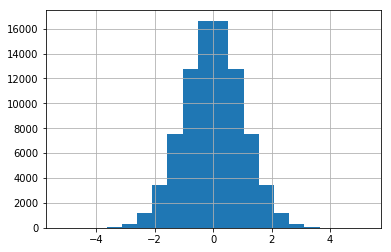

In [54]:
scaled_quant_df["dist_to_bigben"].hist(bins=20)
plt.show()

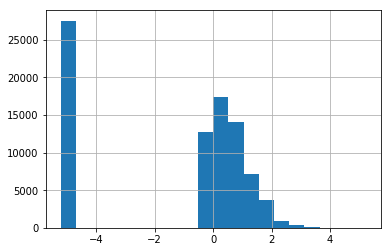

In [55]:
scaled_quant_df["cleaning_fee"].hist(bins=20)
plt.show()

Aside from the "dist_to_bigben" feature, unfortunately, using both powertransform and quantiletransform did not result in a good transformation to normal distribution for most of these scaled features. Nevertheless, we will test these in our model.

In [56]:
X = pd.concat([ohe, scaled_quant_df], axis=1)
y = df["price"]

In [58]:
%%time
lr = build_and_train_model(X, y, SGDR_model)

SGD Regression
Training Score: 0.4220883743393836
Testing Score: 0.4124481518512485
RMSE: 79.45742306575083
Wall time: 1.06 s


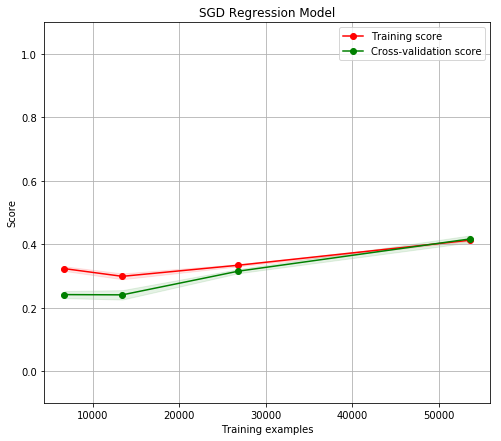

Wall time: 5.51 s


In [61]:
%%time
plot_learning_curves(X, y, sgdr, 
                     "SGD Regression Model")

We can see a slight performance hit by transforming non-normal data to normal. There is still high bias (underfitting) present at low training size, but both the training and validation scores increase with increasing sample size, indicating the model is able to learn with more data with low variance and low bias.

It seems the stochastic gradient descent linear regression model has reached its limit, so we will try other models. Although we do not expect much signal to be squeezed out since most of the features simply do not correlate very well with the listing price.

### Applying Principle Component Analysis

This is just to identify which features explain the most variance in the data. It will not be used for model training.

In [62]:
from sklearn.decomposition import PCA

def apply_pca(X, n, add_constant=False):
    pca = PCA(n_components = n)
    x_new = pca.fit_transform(X)
    if add_constant is True:
        x_new = sm.add_constant(x_new)
    return pca, pd.DataFrame(x_new)

In [63]:
pca, _ = apply_pca(X.drop("price", axis=1), 6)
print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.33647916 0.17734673 0.15392215 0.1058665  0.06559772 0.03953011]


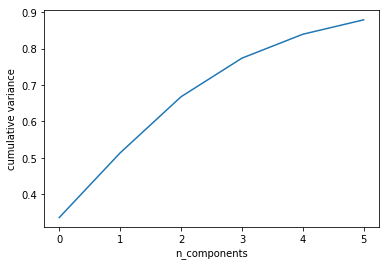

In [64]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("n_components")
plt.ylabel("cumulative variance")
plt.show()

So it seems just 10 components explains more than 90% of the variance in the data

In [65]:
pd.DataFrame(pca.components_, 
             columns=X.drop("price", axis=1).columns, 
            index=["pc-1", "pc-2", "pc-3", "pc-4", "pc-5", "pc-6"]) 

,no pets,no friends,no parties,no smoking,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,...,bathrooms,bedrooms,beds,number_of_reviews,security_deposit,cleaning_fee,dist_to_bigben,dist_to_bigben_transformed,minimum_nights,maximum_nights
pc-1,0.009800,-0.000076,0.022358,0.010915,-0.059362,-0.002128,0.014307,-0.000013,-0.002523,-0.000059,...,0.051075,0.097483,0.092731,0.174731,0.699216,0.592798,0.008668,-0.003578,0.301271,0.022806
pc-2,-0.001137,0.000002,-0.001946,-0.006743,-0.020859,-0.001103,0.001187,-0.000014,-0.001078,-0.000060,...,0.022704,0.054547,0.027496,-0.396363,-0.164296,-0.158653,-0.005186,-0.013021,0.886310,-0.008256
pc-3,0.007039,-0.000160,0.005082,-0.009065,-0.006698,0.000879,-0.010307,0.000037,0.000384,-0.000042,...,0.025207,0.043077,0.033891,-0.828661,0.437053,-0.129266,0.010912,-0.005982,-0.317410,0.013844
pc-4,-0.000883,0.000118,-0.004042,0.011845,0.026961,0.000272,-0.007154,-0.000012,0.001028,0.000037,...,-0.042549,-0.085407,-0.082198,0.338122,0.536141,-0.745902,-0.002151,0.016043,0.127696,-0.030905
pc-5,-0.007305,0.000098,-0.009534,-0.003899,0.052575,-0.000823,0.046326,0.000066,-0.000011,-0.000030,...,-0.239717,-0.761361,-0.439369,-0.100962,0.061651,0.198867,-0.033207,-0.015515,0.073304,-0.009290
pc-6,0.005424,0.000090,-0.001934,0.000957,-0.012615,-0.000894,-0.017030,-0.000030,0.002311,0.000106,...,0.003655,-0.056180,0.012160,-0.008498,-0.010663,0.007312,0.704287,0.696665,0.012349,0.002795


Get the index of the most important feature for each principal component row based on the largest absolute value

In [66]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(6)]
most_important_names = [X.drop("price", axis=1).columns[most_important[i]] for i in range(6)]
dic = {'PC-{}'.format(i+1): most_important_names[i] for i in range(6)}
pc = pd.DataFrame(sorted(dic.items()), columns=["PC", "FEATURES"])
pc

,PC,FEATURES
0,PC-1,security_deposit
1,PC-2,minimum_nights
2,PC-3,number_of_reviews
3,PC-4,cleaning_fee
4,PC-5,bedrooms
5,PC-6,dist_to_bigben


## Implementing Gradient Boosting Regressor model

In [87]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [88]:
X = pd.concat([ohe, scaled_quant_df], axis=1)
y = df["price"]

In [99]:
def gbr_model():
    """
    Gradient Boosting Regressor with Grid Seach CV.
    
    Note: This is extremely computationally intensive hence
          parameters have been hardcoded for now.
    
    n_estimators: Number of weak learners (small decision trees)
    max_depth: The maximum depth of each individual decision tree
    min_samples_split: A decision tree node should have at least x samples before it is split
    learning_rate: Scales output of each decision tree model by a constant learning rate (shrinkage).                    
    loss: loss function to be optimised (least squares)
    
    Returns GBR model 
    """
    num_estimators = [100]
    learn_rates = [0.1]
    max_depths = [5]
    
    params = {"n_estimators" : num_estimators,
              "max_depth" : max_depths,
              "learning_rate" : learn_rates
             }
    
    gbr_model = GridSearchCV(GradientBoostingRegressor(min_samples_split=2, loss="ls"),
                             params, return_train_score=True
                            )
    
    return gbr_model

In [100]:
%%time
gbr = build_and_train_model(X, y, gbr_model)

Training Score: 0.6239331857765287
Testing Score: 0.5609262737254702
RMSE: 68.68787847968943
Wall time: 1min 38s


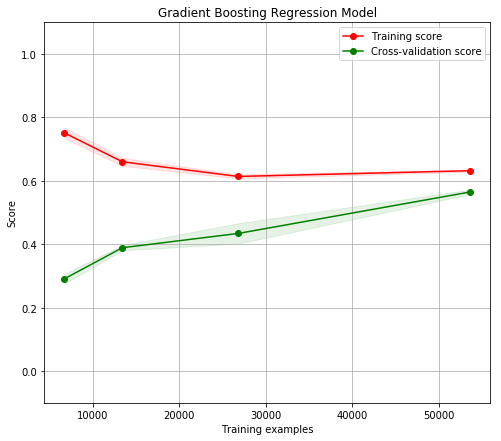

Wall time: 3min 39s


In [101]:
%%time
plot_learning_curves(X, y, gbr_model(), "Gradient Boosting Regression Model")

The GBR model clearly outperforms the SGDR model with its low RMSE and higher R^2. However, this model seems to suffer from high variance and bias and low training size. The hyperparameters need to be adjusted, but gradient boosting is very computationally intensive on my current system, hence further training will not be attempted further.

### Most important features of Gradient Boosting Model

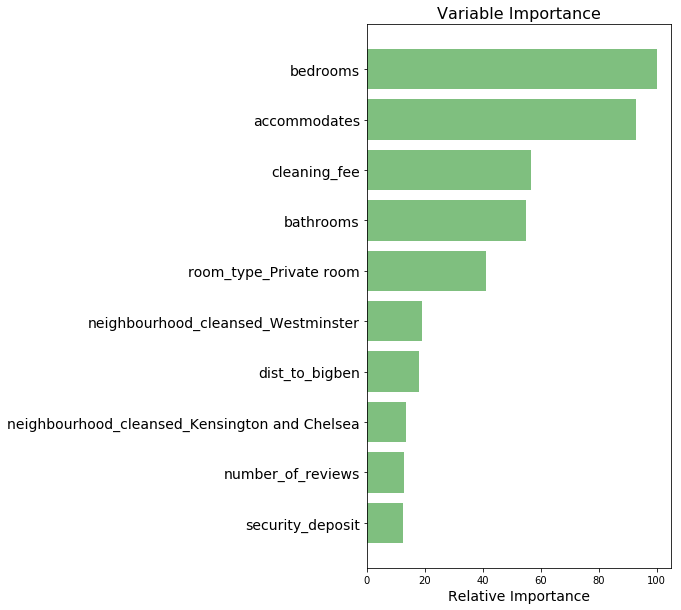

In [147]:
# Plot feature importance 
feature_importance = gbr["model"].best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12,10))
plt.subplot(1, 2, 2)
pos = pos[::-1][0:10]
sorted_idx = sorted_idx[::-1][0:10]
plt.barh(pos, feature_importance[sorted_idx], align='center', color="g", alpha=0.5)
plt.yticks(pos, X.drop("price",axis=1).columns[sorted_idx], fontsize=14)
plt.xlabel('Relative Importance', fontsize=14)
plt.title('Variable Importance', fontsize=16)
plt.show()

## Summary of models

### Comparison of model metrics

| Model | Train score | Test score | RMSE |
| --- | --- | --- | --- |
| SGD Regressor | 0.42 | 0.41 | 79.45 |
| Gradient Boosting Regressor | 0.62 | 0.56 | 68.68 |


The GBR model clearly outperforms the SGDR model as can be seen in the table above. We achieved a relevatively low RMSE of 68.68, which is much lower compared to another benchmark for this project [[1]](https://www.dataquest.io/blog/machine-learning-tutorial/). For both models, the cross validation score increases with training size indicating that the model is able to learn only with increasing training sample size. Based on the learning curves for the GBR model, we can see there is high variance at low training size indicating overfitting. This means we may need to reduce the number of weak learners, max depth and the learning rate. This can be done using GridSearchCV, but it is extremely computationally intensive. 

The low R^2 score in general seems to indicate our model is just not complex enough with the current set of features. We may need to engineer more features using techniques like NLP as there are a lot more categorical features in the original raw dataset. Furthermore, there were also image URLS for each of the listings (which were removed in the clean dataset), and computer vision techniques could potentially be used to extract the most common color palette which might have an affect on the price. However, these techniques are generally very computationally intensive and may need access to a high performance local or cloud computing cluster.